<a href="https://colab.research.google.com/github/medsellufbc/BMI/blob/main/ExpLogistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
from pathlib import Path

loadpy = Path('load_covid_data.py')
if not loadpy.exists():
    ! wget https://raw.githubusercontent.com/github/covid19-dashboard/master/_notebooks/load_covid_data.py

--2022-12-06 20:39:14--  https://raw.githubusercontent.com/github/covid19-dashboard/master/_notebooks/load_covid_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3315 (3.2K) [text/plain]
Saving to: ‘load_covid_data.py’

load_covid_data.py  100%[===================>]   3.24K  --.-KB/s    in 0s      

2022-12-06 20:39:14 (37.9 MB/s) - ‘load_covid_data.py’ saved [3315/3315]



In [ ]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 24.3 MB/s 
     |████████████████████████████████| 1.8 MB 55.7 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=f7497a864dfcfaf52ceadf007cdf808ca064c090476f6927f63540cb067ab3cc
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


In [ ]:
#hide
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm

import load_covid_data

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

## Set this to true to see legacy charts
debug=False


In [ ]:
#hide

df = load_covid_data.load_data(drop_states=True, filter_n_days_100=2)
# We only have data for China after they already had a significant number of cases.
# They also are not well modeled by the exponential, so we drop them here for simplicity.
df = df.loc[lambda x: x.country != 'China (total)']

countries = df.country.unique()
n_countries = len(countries)
df = df.loc[lambda x: (x.days_since_100 >= 0)]

annotate_kwargs = dict(
    s='Based on COVID Data Repository by Johns Hopkins CSSE ({})\nBy Thomas Wiecki'.format(df.index.max().strftime('%B %d, %Y')),
    xy=(0.05, 0.01), xycoords='figure fraction', fontsize=10)


In [ ]:
#hide_input
',   '.join(sorted(df.country.unique().tolist()))


"Afghanistan,   Albania,   Algeria,   Andorra,   Angola,   Antigua and Barbuda,   Argentina,   Armenia,   Australia (total),   Austria,   Azerbaijan,   Bahamas,   Bahrain,   Bangladesh,   Barbados,   Belarus,   Belgium,   Belize,   Benin,   Bhutan,   Bolivia,   Bosnia and Herzegovina,   Botswana,   Brazil,   Brunei,   Bulgaria,   Burkina Faso,   Burma,   Burundi,   Cabo Verde,   Cambodia,   Cameroon,   Canada (total),   Central African Republic,   Chad,   Chile,   Colombia,   Comoros,   Congo (Brazzaville),   Congo (Kinshasa),   Costa Rica,   Cote d'Ivoire,   Croatia,   Cuba,   Cyprus,   Czechia,   Denmark,   Denmark (total),   Diamond Princess,   Djibouti,   Dominica,   Dominican Republic,   Ecuador,   Egypt,   El Salvador,   Equatorial Guinea,   Eritrea,   Estonia,   Eswatini,   Ethiopia,   Fiji,   Finland,   France,   France (total),   Gabon,   Gambia,   Georgia,   Germany,   Ghana,   Greece,   Grenada,   Guatemala,   Guinea,   Guinea-Bissau,   Guyana,   Haiti,   Honduras,   Hong Ko

In [ ]:
country = 'US'
df_country = df.loc[lambda x: (x.country == country)].iloc[:50]


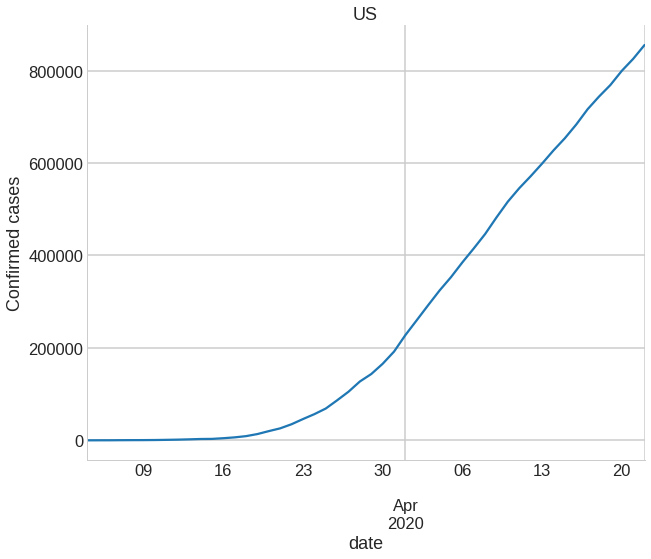

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
df_country.confirmed.plot(ax=ax)
ax.set(ylabel='Confirmed cases', title=country)
sns.despine()


In [ ]:
t = df_country.days_since_100.values
confirmed = df_country.confirmed.values

with pm.Model() as model:
    # Intercept
    a = pm.Normal('a', mu=0, sigma=25)

    # Slope
    b = pm.Normal('b', mu=0.3, sigma=0.3)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Error term
    eps = pm.HalfNormal('eps')

    # Likelihood
    pm.Normal('US',
              mu=growth,
              sigma=eps,
              observed=confirmed)

In [ ]:
with model:
    prior_pred = pm.sample_prior_predictive()


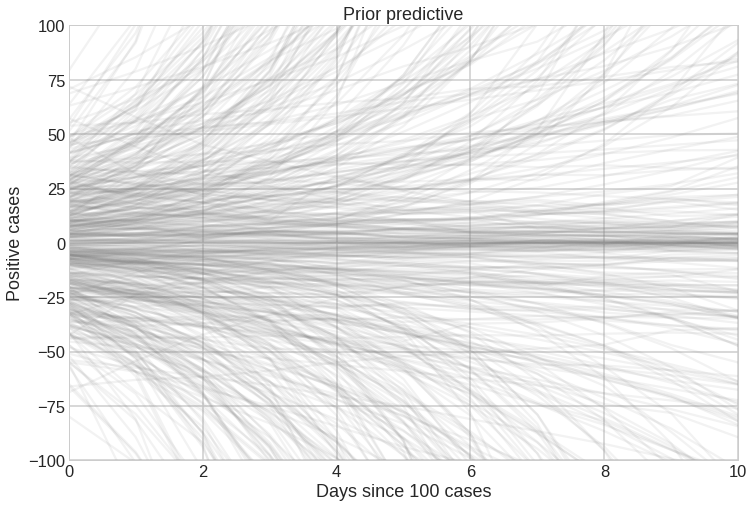

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred['US'].T, color="0.5", alpha=.1);
ax.set(ylim=(-100, 100),
       xlim=(0, 10),
       title="Prior predictive",
       xlabel="Days since 100 cases",
       ylabel="Positive cases");


In [ ]:
t = df_country.days_since_100.values
confirmed = df_country.confirmed.values

with pm.Model() as model:
    # Intercept
    a = pm.Normal('a', mu=100, sigma=25)

    # Slope
    b = pm.Normal('b', mu=0.3, sigma=0.1)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Error term
    eps = pm.HalfNormal('eps')

    # Likelihood
    pm.Lognormal('US',
                 mu=pm.math.log(growth),
                 sigma=eps,
                 observed=confirmed)


In [ ]:
with model:
    prior_pred = pm.sample_prior_predictive()


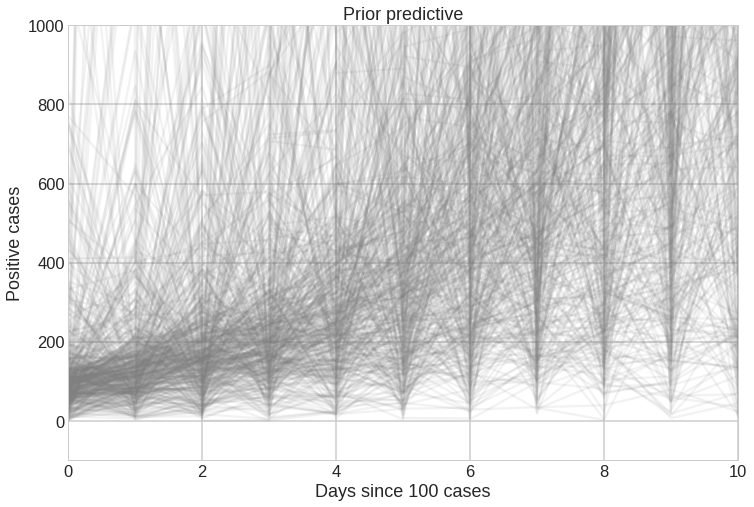

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred['US'].T, color="0.5", alpha=.1);
ax.set(ylim=(-100, 1000),
       xlim=(0, 10),
       title="Prior predictive",
       xlabel="Days since 100 cases",
       ylabel="Positive cases");


In [ ]:
with model:
    # Inference button (TM)
    trace = pm.sample(cores=4, chains=4)


/usr/local/lib/python3.8/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


<ipython-input-16-c386196b5d9e>:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


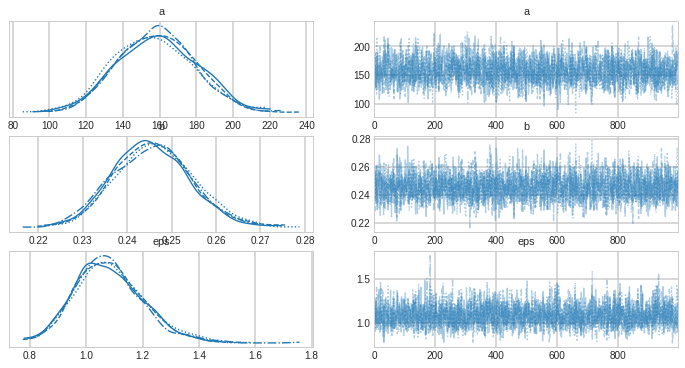

In [ ]:
with model:
    pm.traceplot(trace);

In [ ]:
with model:
    print(pm.rhat(trace))


<xarray.Dataset>
Dimensions:  ()
Data variables:
    a        float64 1.002
    b        float64 1.003
    eps      float64 1.001


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


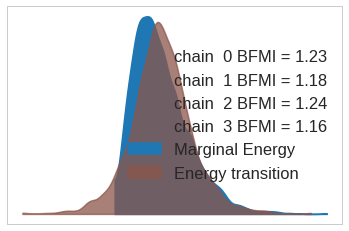

In [ ]:
pm.plot_energy(trace);

In [ ]:
with model:
    # Draw sampels from posterior predictive
    post_pred = pm.sample_posterior_predictive(trace)


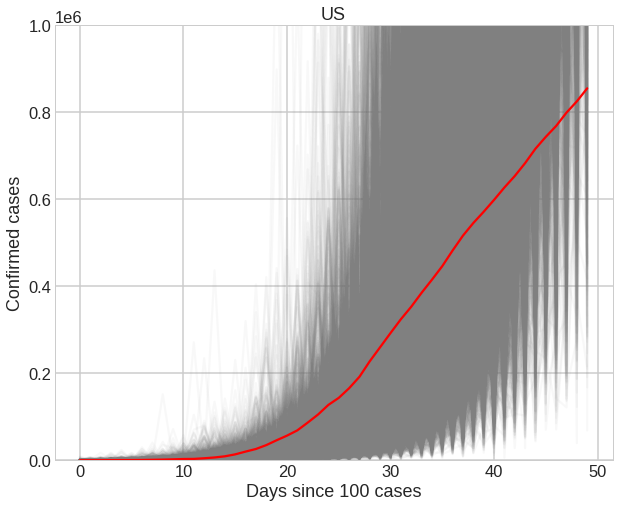

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(post_pred['US'].T, color='0.5', alpha=.05);
ax.plot(confirmed, color='r')
ax.set(xlabel='Days since 100 cases', ylabel='Confirmed cases',
       ylim=(0, 1_000_000), title=country);


In [ ]:
with pm.Model() as model:
    ############
    # Intercept
    # Group mean
    a_grp = pm.Normal('a_grp', 100, 50)
    # Group sd
    a_grp_sigma = pm.HalfNormal('a_grp_sigma', 50)
    # Individual intercepts
    a_ind = pm.Normal('a_ind',
                      mu=a_grp, sigma=a_grp_sigma,
                      shape=n_countries)
    ########
    # Slope
    # Group mean
    b_grp = pm.Normal('b_grp', 1.33, .5)
    # Group sd
    b_grp_sigma = pm.HalfNormal('b_grp_sigma', .5)
    # Individual slopes
    b_ind = pm.Normal('b_ind',
                      mu=b_grp, sigma=b_grp_sigma,
                      shape=n_countries)

    eps = pm.HalfNormal('eps')

    # Create likelihood for each country
    for i, country_name in enumerate(countries):
        df_country = df.loc[lambda x: (x.country == country)]

        growth = a_ind[i] * b_ind[i] ** df_country.days_since_100

        # Likelihood
        pm.Lognormal(
            country_name,
            mu=pm.math.log(growth),
            sigma=eps,
            observed=df_country.confirmed)

In [ ]:
x = df_country.days_since_100.values
cases = df_country.confirmed.values

with pm.Model() as logistic_model:
    # Define priors
    intercept = pm.Normal('a', mu=100, sigma=30)
    b = pm.Normal('b', .3, .1)
    carrying_capacity = pm.Uniform('carrying_capacity',
                                   lower=1_000,
                                   upper=10_000_000)

    a = carrying_capacity / intercept - 1

    # Logistic
    growth = carrying_capacity / (1 + a * pm.math.exp(-b * x))

    eps = pm.HalfNormal('eps', 1)

    # Likelihood
    pm.Lognormal('US', pm.math.log(growth), eps, observed=cases)


In [ ]:
with logistic_model:
    # Inference
    trace = pm.sample(tune=1000, chains=4, cores=4, target_accept=.9)

    # Sample posterior predcitive
    post_pred = pm.sample_posterior_predictive(trace, samples=100)


/usr/local/lib/python3.8/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


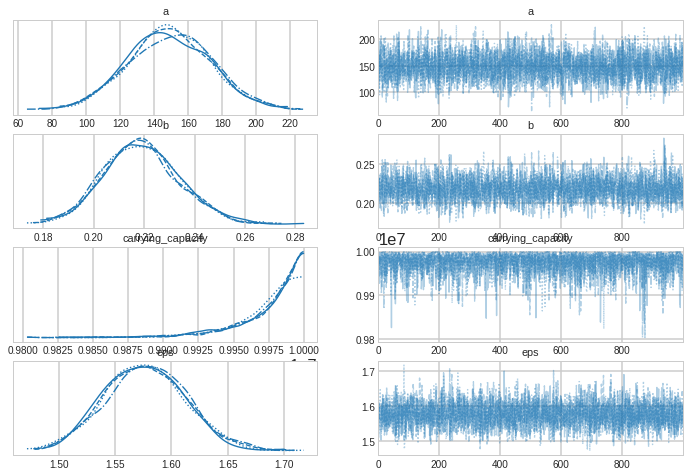

In [ ]:
with logistic_model:
    pm.plot_trace(trace)


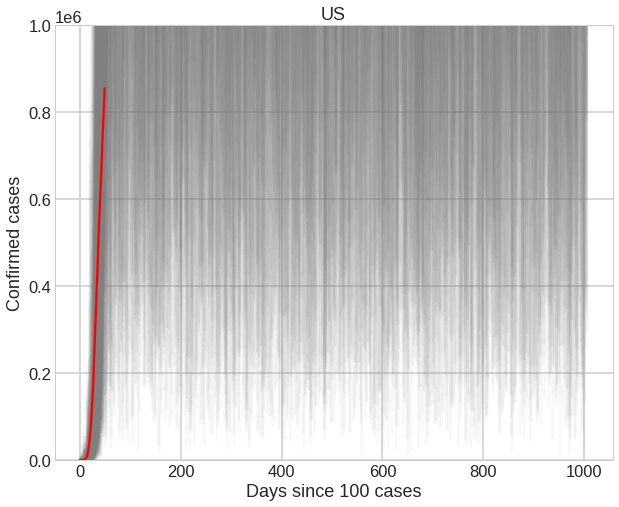

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(post_pred['US'].T, color='0.5', alpha=.05);
ax.plot(confirmed, color='r')
ax.set(xlabel='Days since 100 cases', ylabel='Confirmed cases',
       ylim=(0, 1_000_000), title=country);


In [ ]:
#hide

#####################################
##### This Cell Runs The Model ######
#####################################

with pm.Model() as model:
    ############
    # Intercept
    # Group mean
    a_grp = pm.Normal('a_grp', 100, 50)
    # Group sd
    a_grp_sigma = pm.HalfNormal('a_grp_sigma', 50)
    # Individual intercepts
    a_ind = pm.Normal('a_ind',
                      mu=a_grp, sigma=a_grp_sigma,
                      shape=n_countries)
    ########
    # Slope
    # Group mean
    b_grp = pm.Normal('b_grp', 1.33, .5)
    # Group sd
    b_grp_sigma = pm.HalfNormal('b_grp_sigma', .5)
    # Individual slopes
    b_ind = pm.Normal('b_ind',
                      mu=b_grp, sigma=b_grp_sigma,
                      shape=n_countries)

    eps = pm.HalfNormal('eps')
    # Create likelihood for each country
    for i, country in enumerate(countries):
        df_country = df.loc[lambda x: (x.country == country)]

        # By using pm.Data we can change these values after sampling.
        # This allows us to extend x into the future so we can get
        # forecasts by sampling from the posterior predictive
        x = pm.Data(country + "x_data",
                    df_country.days_since_100.values)
        confirmed = pm.Data(country + "y_data",
                            df_country.confirmed.astype('float64').values)

        # Likelihood
        pm.Lognormal(
            country,
            mu=pm.math.log(a_ind[i] * b_ind[i] ** x), # Exponential regression
            sigma=eps,
            observed=confirmed)


In [ ]:
!pip install altair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#hide
with model:
    # Sample posterior
    trace = pm.sample(tune=1500, chains=1, cores=2, target_accept=.9)

    # Update data so that we get predictions into the future
    for country in countries:
        df_country = df.loc[lambda x: (x.country == country)]
        x_data = np.arange(0, 30)
        y_data = np.array([np.nan] * len(x_data))
        pm.set_data({country + "x_data": x_data})
        pm.set_data({country + "y_data": y_data})

    # Sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace, samples=80)

/usr/local/lib/python3.8/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


SamplingError: ignored

In [ ]:
#hide

##############################################
#### Pre processing of Data For Altair Viz ###
##############################################

# Flatten predictions & target for each country into a pandas DataFrame
prediction_dfs_list = []

for country in post_pred:
    arr = post_pred[country]
    preds = arr.flatten().tolist() # get predictions in a flattened array
    pred_idx = np.indices(arr.shape)[0].flatten().tolist() # prediction for model (there are many per country, thes are the grey lines)
    days_since = np.indices(arr.shape)[1].flatten().tolist() # days since 100 cases
    pred_df = pd.DataFrame({'country': country,
                            'predictions': preds,
                            'pred_idx': pred_idx,
                            'days_since_100': days_since}
                          )
    prediction_dfs_list.append(pred_df)

predictionsDF = pd.concat(prediction_dfs_list)


# Compute the maximum value to plot on the y-axis as 15x the last confirmed case
ylims = pd.DataFrame(df.groupby('country').last().confirmed * 15).reset_index()
ylims.columns = ['country', 'ylim']


# Filter out any predictions exceed the y-axis limit
predictionsDF_filtered = (predictionsDF.merge(ylims, on='country', how='left')
                         .loc[lambda x: x.predictions <= x.ylim])


# Compute a 33% daily growth rate (dashed line) as a reference for visualizations
first_case_count = df.groupby('country').first().confirmed.reset_index()
date_anchor = predictionsDF_filtered[['country', 'days_since_100']].drop_duplicates()
max_pred = predictionsDF_filtered.groupby('country').max()[['predictions']].reset_index()
benchmark = (date_anchor
             .merge(first_case_count, on='country', how='left')
             .merge(max_pred, on='country', how='left')
            )
benchmark['benchmark'] = benchmark.apply(lambda x: x.confirmed * (1.3**(x.days_since_100)),
                                         axis=1)
benchmarkDF_filtered = benchmark.loc[lambda x: x.benchmark <= x.predictions]


# Compute the last known total confirmed case, which is the black dot at the end of the red line in the viz
lastpointDF = df.groupby('country').last().reset_index()


# DataFrame of Chart Titles by country.  This a enables a hack to allow Altiar to switch values
titleDF = lastpointDF[['country']]
titleDF['title'] = titleDF.apply(lambda x: x.country + ': Actual vs. Predicted Growth',
                             axis=1)


<ipython-input-28-c14e92e88ac6>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titleDF['title'] = titleDF.apply(lambda x: x.country + ': Actual vs. Predicted Growth',


In [ ]:
#hide_input

##################################
#### Construct The Altair Viz ####
##################################

alt.data_transformers.disable_max_rows()

selectCountry = alt.selection_single(
    name='Select',
    fields=['country'],
    init={'country': 'US'},
    bind=alt.binding_select(options=sorted(countries.tolist()))
)

##### Model Predictions (Grey) #####
width = 275
height= 250

pred = (alt.Chart(predictionsDF_filtered)
        .mark_line(opacity=.15)
        .encode(x=alt.X('days_since_100:Q', axis=alt.Axis(title='Days since 100th confirmed case')),
                y=alt.Y('predictions:Q',
                        axis=alt.Axis(title='Confirmed cases')),
                color=alt.Color('pred_idx:Q', legend=None, scale=None),)
        .transform_filter(selectCountry)
       ).properties(
    width=width,
    height=height
)

predlog = (alt.Chart(predictionsDF_filtered)
        .mark_line(opacity=.15)
        .encode(x=alt.X('days_since_100:Q', axis=alt.Axis(title='Days since 100th confirmed case')),
                y=alt.Y('predictions:Q',
                        axis=alt.Axis(title=None),
                        scale=alt.Scale(type='log', base=10)),
                color=alt.Color('pred_idx:Q', legend=None, scale=None),)
        .transform_filter(selectCountry)
        ).properties(
    width=width,
    height=height
)

##### Mark The Last Case Count #####

# Point

last_point = (alt.Chart(lastpointDF)
              .mark_circle(color="black", size=40)
              .encode(x='days_since_100:Q',
                      y='confirmed:Q')
              .transform_filter(selectCountry)
             )

# Label
last_point_label = (alt.Chart(lastpointDF)
                    .mark_text(align='right', dx=-10, dy=-15, fontSize=15)
                    .encode(x='days_since_100:Q',
                            y='confirmed:Q',
                            text='confirmed')
                    .transform_filter(selectCountry)
                   )

##### Place 133% Dotted Line Reference On Graph #####
guide = (alt.Chart(benchmarkDF_filtered)
        .mark_line(color='black', opacity=.5, strokeDash=[3,3])
        .encode(x='days_since_100:Q',
                y='benchmark:Q',
                )
        .transform_filter(selectCountry)
        )


##### Dynamic Chart Title


title_main = alt.Chart(titleDF).mark_text(dy=-15, dx=325, size=20).encode(
    text='title:N'
    ).transform_filter(selectCountry)


title_linear = (alt.Chart(alt.Data(values=[{'title': 'Y axis is on a linear scale'}]))
                .mark_text(dy=-150, size=15)
                .encode(text='title:N')
               )
title_log = (alt.Chart(alt.Data(values=[{'title': 'Y axis is on a log scale'}]))
                .mark_text(dy=-150, size=15)
                .encode(text='title:N')
               )

###### Legend (Hacked)
source = pd.DataFrame.from_records([{"img": "https://covid19dashboards.com/images/covid-bayes-growth-legend.png"}])
legend = (alt.Chart(source)
          .mark_image(dy=-150,
                      width=200,
                      height=150)
          .encode(url='img')
         )

##### Actual Cases (Red) #####
actual = (alt.Chart(df).mark_line(color="red")
          .encode(x='days_since_100:Q',
                  y='confirmed:Q')
          .transform_filter(selectCountry)
         )

annotations = last_point + last_point_label + guide + actual
linear_chart = pred.add_selection(selectCountry) + annotations + title_linear
log_chart = predlog + annotations + title_log + title_log

##### Layer All Charts Together And Configure Formatting #####
(
((title_main + legend) & ( linear_chart | log_chart ))
.configure_title(fontSize=20)
.configure_axis(labelFontSize=15,titleFontSize=18, grid=False)
)


NameError: ignored